**Notebook 4-2-Fase 1** (v6)

Capa Silver (2): análisis de la correlación

Dataset: **2023/01**

Objetivos del presente notebook:
- Análisis de correlación
- Paso a la capa Gold

Versiones:
- v1: código traspasado desde la v2 del notebook 3
- v2: estudio de la correlación, reducción de dimensionalidad y clustering
- v3: limpieza de v2 -> problemas de memoria, lo paso a v4
- v4: gestión de memoria: no funciona
- v5: vuelvo a v3, separo en fases
- v6: limpieza de v5; acabado

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pyspark.sql import SparkSession, DataFrame

from pyspark.sql.functions import (
    sum as spark_sum,
    min as spark_min,
    max as spark_max,
    round as spark_round,
    pi as spark_pi,
    count, col, when, isnan, isnull, mean, stddev, desc, asc,
    year, month, dayofweek, dayofmonth, weekofyear, date_format, to_date,
    isnotnull, date_trunc, datediff, lit, percentile_approx, expr, broadcast,
    coalesce, avg, hour, unix_timestamp, sin, cos, udf
)

from pyspark.sql.types import (
    NumericType, StringType, DateType, TimestampType, DoubleType, BooleanType,
    IntegerType
)

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    StringIndexer, StandardScaler, MinMaxScaler, VectorAssembler, StringIndexerModel,
    OneHotEncoder
)
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

from datetime import datetime

from google.colab import drive

from mpl_toolkits.mplot3d import Axes3D

import os
import re
import json
import time
import sys
import gc

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
SILVER_DIR = f"{PROJECT_ROOT}/silver"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# crea directorios si no existen
paths = [BRONZE_DIR, SILVER_DIR, METADATA_DIR]

for path in paths:
    os.makedirs(path, exist_ok=True)

In [5]:
# dataset preparado para correlaciones
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_251109"

In [6]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [7]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [8]:
def get_bronze_dataset_paths(bronze_root):
    """
    Devuelve todas las rutas individuales de datasets en la capa Bronze.

    Args:
        bronze_root (str): Ruta raíz de la capa Bronze.

    Returns:
        list: Lista de rutas individuales de datasets.
    """
    parquet_dirs = []
    for root, _, files in os.walk(bronze_root):
        if any(f.endswith(".parquet") for f in files):
            parquet_dirs.append(root)
    return sorted(parquet_dirs)

In [9]:
def extract_year_month_from_hive_partition(path):
    """
    Extrae año y mes de la estructura de particiones de Hive.

    Args:
        path (str): Ruta del dataset con estructura ingestion_year=YYYY/ingestion_month=MM

    Returns:
        tuple: (año, mes) o (None, None) si no se puede extraer
    """
    # busca patrones de partición de Hive en la ruta completa
    year_pattern = r'ingestion_year=(\d{4})'
    month_pattern = r'ingestion_month=(\d{1,2})'

    year_match = re.search(year_pattern, path)
    month_match = re.search(month_pattern, path)

    if year_match and month_match:
        year = int(year_match.group(1))
        month = int(month_match.group(1))

        # valida que el mes esté en rango válido
        if 1 <= month <= 12:
            return year, month

    return None, None

In [10]:
def format_date_info(year, month):
    """
    Formatea la información de fecha para mostrar.

    Args:
        year (int): Año
        month (int): Mes

    Returns:
        str: Fecha formateada
    """
    if year and month:
        try:
            # crea objeto datetime para obtener el nombre del mes
            date_obj = datetime(year, month, 1)
            month_names_es = {
                1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
                5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
                9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
            }
            return f"{year}-{month:02d} ({month_names_es[month]} {year})"
        except ValueError:
            return f"{year}-{month:02d}"
    return "Fecha no identificada"

In [11]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

- **Carga y guardado de ficheros**

In [12]:
def save_parquet(df, ruta, modo="overwrite", compresion="snappy"):
    """
    Guarda un DataFrame en formato Parquet.

    Args:
        df: DataFrame de PySpark
        ruta: str, ruta donde guardar el archivo
        modo: str, modo de escritura ("overwrite", "append", "ignore", "error")
        compresion: str, tipo de compresión ("snappy", "gzip", "lzo", "brotli", "lz4", "zstd")

    Returns:
        True si se guardó correctamente, False en caso contrario
    """
    try:
        print(f"💾 Guardando DataFrame en {ruta}...")
        print(f"📊 Registros a guardar: {df.count()}")

        df.write \
          .mode(modo) \
          .option("compression", compresion) \
          .parquet(ruta)

        print(f"✅ Dataframe guardado correctamente en {ruta}")

        return True

    except Exception as e:
        print(f"❌ Error al guardar: {str(e)}")

        return False

In [13]:
def load_parquet(spark, ruta, mostrar_info=True):
    """
    Lee un DataFrame en formato Parquet.

    Args:
        spark: sesión de Spark
        ruta: str, ruta del archivo Parquet a leer
        mostrar_info: str, True para mostrar información del DataFrame leído

    Returns:
        DataFrame leído o None si hay error
    """
    try:
        print(f"📖 Leyendo DataFrame desde {ruta}...")

        df_leido = spark.read.parquet(ruta)

        if mostrar_info:
            filas = df_leido.count()
            columnas = len(df_leido.columns)
            print("✅ Dataframe cargado correctamente")
            print(f"📊 Registros leídos: {filas}")
            print(f"📋 Columnas: {columnas}")
            print(f"🏷️  Nombres de columnas: {df_leido.columns}")
        else:
            print("✅ Dataframe cargado correctamente")

        return df_leido

    except Exception as e:
        print(f"❌ Error al leer el Dataframe: {str(e)}")
        return None

- **Correlación**

In [14]:
def compute_correlation_matrix(ds_spark, variables_list, method="pearson"):
    """
    Calcula la matriz de correlación para un grupo de variables

    Args:
        ds_spark: DataFrame de PySpark
        variables_list: lista de nombres de columnas a correlacionar
        method: método de correlación ('pearson' o 'spearman')

    Returns:
        correlation_matrix: matriz de correlación como array numpy
        variables_list: lista de variables (para etiquetas)
    """

    print(f"🔄 Calculando correlaciones de {method} para {len(variables_list)} variables...")

    # comprueba que todas las variables existan en el DataFrame
    available_cols = ds_spark.columns
    missing_vars = [var for var in variables_list if var not in available_cols]

    if missing_vars:
        print(f"⚠️  Variables no encontradas: {missing_vars}")
        variables_list = [var for var in variables_list if var in available_cols]
        print(f"📝 Variables disponibles: {len(variables_list)}")

    if len(variables_list) < 2:
        raise ValueError("Se necesitan al menos 2 variables para calcular correlaciones")

    # crea vector de características
    assembler = VectorAssembler(
        inputCols=variables_list,
        outputCol="features",
        handleInvalid="skip"  # omite registros con valores nulos
    )

    # transforma dataframe en un vector
    ds_vector = assembler.transform(ds_spark).select("features")

    # calcula matriz de correlación
    correlation_matrix = Correlation.corr(ds_vector, "features", method).collect()[0][0]

    # convierte a numpy (copia los datos fuera de Spark)
    correlation_array = correlation_matrix.toArray().copy()

    # libera memoria
    ds_vector.unpersist()
    del correlation_matrix, ds_vector, assembler
    gc.collect()

    return correlation_array, variables_list

In [15]:
def analyze_correlation_group(ds_spark, variables_list, group_name="Variables", method="pearson"):
    """
    Análisis completo de correlaciones para un grupo de variables

    Args:
        ds_spark: DataFrame de PySpark
        variables_list: lista de variables a analizar
        group_name: nombre del grupo (para títulos e informes)
        method: método de correlación ('pearson' o 'spearman')

    Returns:
        correlation_matrix: matriz de correlación
        df_correlation: DataFrame de Pandas con la matriz
        summary_stats: resumen de estadísticas
    """
    print(f"\n{'='*60}")
    print(f"📊 ANÁLISIS DE CORRELACIÓN - {group_name.upper()}")
    print(f"{'='*60}")

    # calcula matriz de correlación
    corr_matrix, final_variables = compute_correlation_matrix(ds_spark, variables_list, method)

    # convierte a DataFrame de Pandas para análisis
    df_correlation = pd.DataFrame(
        corr_matrix,
        index=final_variables,
        columns=final_variables
    )

    # resumen de estadísticas
    summary_stats = calculate_correlation_summary(df_correlation)

    # muestra resumen
    print_correlation_summary(summary_stats, group_name)

    return corr_matrix, df_correlation, summary_stats

In [16]:
def calculate_correlation_summary(df_correlation):
    """
    Calcula un resumen de estadísticas de la matriz de correlación

    Args:
        df_correlation: DataFrame de Pandas con la matriz de correlación

    Returns:
        summary: diccionario con estadísticas
    """
    # obtiene sólo la matriz triangular superior (sin diagonal)
    mask = np.triu(np.ones_like(df_correlation.values, dtype=bool), k=1)
    upper_triangle = df_correlation.values[mask]

    # estadísticas
    summary = {
        'total_pairs': len(upper_triangle),
        'mean_correlation': np.mean(upper_triangle),
        'max_correlation': np.max(upper_triangle),
        'min_correlation': np.min(upper_triangle),
        'std_correlation': np.std(upper_triangle),
        'high_correlations': np.sum(np.abs(upper_triangle) > 0.7),
        'moderate_correlations': np.sum((np.abs(upper_triangle) > 0.3) & (np.abs(upper_triangle) <= 0.7)),
        'low_correlations': np.sum(np.abs(upper_triangle) <= 0.3),
    }

    return summary

In [17]:
def print_correlation_summary(summary_stats, group_name):
    """
    Imprime un resumen de las estadísticas de correlación

    Args:
        summary_stats: diccionario con estadísticas
        group_name: nombre del grupo (para títulos e informes)
    """

    print(f"\n📈 RESUMEN ESTADÍSTICO - {group_name}")
    print("-" * 50)
    print(f"Total de pares de variables: {summary_stats['total_pairs']}")
    print(f"Correlación promedio: {summary_stats['mean_correlation']:.3f}")
    print(f"Correlación máxima: {summary_stats['max_correlation']:.3f}")
    print(f"Correlación mínima: {summary_stats['min_correlation']:.3f}")
    print(f"Desviación estándar: {summary_stats['std_correlation']:.3f}")

    print(f"\n🎯 DISTRIBUCIÓN DE CORRELACIONES:")
    print(f"Alto (|r| > 0.7): {summary_stats['high_correlations']} pares")
    print(f"Moderado (0.3 < |r| ≤ 0.7): {summary_stats['moderate_correlations']} pares")
    print(f"Bajo (|r| ≤ 0.3): {summary_stats['low_correlations']} pares")

In [18]:
def plot_correlation_heatmap(df_correlation, group_name="Variables", method="pearson", figsize=(10, 8)):
    """
    Crea un heatmap de la matriz de correlación

    Args:
        df_correlation: DataFrame de Pandas con la matriz de correlación
        group_name: nombre del grupo (para títulos e informes)
        method: método de correlación ('pearson' o 'spearman'), uso sólo para título del gráfico
        figsize: tamaño de la figura (por defecto: (10, 8))
    """
    plt.figure(figsize=figsize)

    # crea máscara para la matriz triangular superior
    #mask = np.triu(np.ones_like(df_correlation.values, dtype=bool))

    # crea máscara para la matriz triangular inferior
    mask = np.tril(np.ones_like(df_correlation.values, dtype=bool), k=0)

    # crea heatmap
    sns.heatmap(
        df_correlation,
        annot=True,
        cmap=sns.diverging_palette(20, 220, n=256),
        center=0,
        square=True,
        mask=mask,
        linewidths=0.5,
        cbar_kws={"shrink": .8},
        fmt='.2f',
        vmin=-1,
        vmax=1
    )

    plt.title(f'Correlación de {method} - {group_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Variables', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # libera memoria
    plt.close('all')

In [19]:
def identify_high_correlations(df_correlation, threshold=0.7):
    """
    Identifica pares de variables con alta correlación

    Args:
        df_correlation: DataFrame de Pandas con la matriz de correlación
        threshold: umbral para identificar correlaciones altas (por defecto: 0.7)

    Returns:
        high_corr_pairs: lista de tuplas (var1, var2, corr_value)
    """

    print(f"\n🔍 CORRELACIONES ALTAS (|r| > {threshold})")
    print("-" * 50)

    # inicializa resultados
    high_corr_pairs = []

    # recorre los pares (fila, columna)
    for i in range(len(df_correlation.columns)):
        for j in range(i+1, len(df_correlation.columns)):

            # correlación del par actual (fila, columna)
            var1 = df_correlation.columns[i]
            var2 = df_correlation.columns[j]
            corr_value = df_correlation.iloc[i, j]

            # compara correlación actual con el valor umbral
            if abs(corr_value) > threshold:
                # superior: guarda correlación actual
                high_corr_pairs.append((var1, var2, corr_value))
                print(f"{var1} ↔ {var2}: {corr_value:.3f}")

    if not high_corr_pairs:
        print("No se encontraron correlaciones altas.")

    return high_corr_pairs

In [20]:
def analyze_correlations(
    ds_spark, variables_list, group_name="Variables",
    method="pearson", plot=True, threshold=0.7
    ):
    """
    Ejecuta análisis completo de correlaciones para un grupo de variables

    Args:
        ds_spark: DataFrame de PySpark
        variables_list: lista de variables a analizar
        group_name: nombre descriptivo del grupo (para títulos e informes)
        method: método de correlación ('pearson' o 'spearman')
        plot: mostrar o no visualizaciones
        threshold: umbral para identificar correlaciones altas

    Returns:
        Diccionario con resultados del análisis
    """
    # realiza análisis
    corr_matrix, df_correlation, summary_stats = analyze_correlation_group(
        ds_spark, variables_list, group_name, method
    )

    # identifica correlaciones altas
    high_correlations = identify_high_correlations(df_correlation, threshold)

    # visualización
    if plot:
        plot_correlation_heatmap(df_correlation, group_name, method)

    # resultado
    results = {
        'correlation_matrix': corr_matrix,
        'df_correlation': df_correlation,
        'summary_stats': summary_stats,
        'high_correlations': high_correlations,
        'variables_analyzed': df_correlation.columns.tolist(),
        'group_name': group_name
    }

    return results

# **1) Carga del Dataset: Enero de 2023 (2023-01)**

In [21]:
# lee dataframe en formato Parquet
ds_for_correlation = load_parquet(spark, dir_dataset, mostrar_info=True)

if ds_for_correlation is None:
    print("❌ El DataFrame no se ha cargado correctamente.")

📖 Leyendo DataFrame desde /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_251109...
✅ Dataframe cargado correctamente
📊 Registros leídos: 3066715
📋 Columnas: 39
🏷️  Nombres de columnas: ['payment_type', 'pickup_hour', 'is_weekend', 'PULocationID_encoded', 'DOLocationID_encoded', 'passenger_count_encoded', 'RatecodeID_encoded', 'trip_distance_encoded', 'extra_encoded', 'tip_amount_encoded', 'tolls_amount_encoded', 'improvement_surcharge_encoded', 'mta_tax_encoded', 'fare_amount_encoded', 'total_amount_encoded', 'congestion_surcharge_encoded', 'airport_fee_encoded', 'trip_duration_minutes_encoded', 'average_speed_mph_encoded', 'tip_percentage_encoded', 'fare_per_mile_encoded', 'proportion_extra_charges_encoded', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_dayofweek', 'tpep_pickup_datetime_week', 'tpep_pickup_datetime_dayofweek_sin', 'tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_dayofweek', 'tpep_dropoff_datetime_

# **2) Correlaciones**

**2.1) Correlaciones por dominios**

Vamos a calcular la correlación de Pearson y de Spearman a los diferentes dominios de variables.

*2.1.1) Identificadores y contexto del servicio*

Variables:

- VendorID_encoded
- RatecodeID_encoded
- store_and_fwd_flag_encoded
- PULocationID_encoded
- DOLocationID_encoded
- payment_type

In [22]:
grupo_de_variables = [
    'VendorID_encoded',
    'RatecodeID_encoded',
    'store_and_fwd_flag_encoded',
    'PULocationID_encoded',
    'DOLocationID_encoded',
    'payment_type'
]

nombre_grupo = "Identificadores y contexto del servicio"


📊 ANÁLISIS DE CORRELACIÓN - IDENTIFICADORES Y CONTEXTO DEL SERVICIO
🔄 Calculando correlaciones de pearson para 6 variables...

📈 RESUMEN ESTADÍSTICO - Identificadores y contexto del servicio
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: 0.047
Correlación máxima: 0.168
Correlación mínima: -0.023
Desviación estándar: 0.063

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 15 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


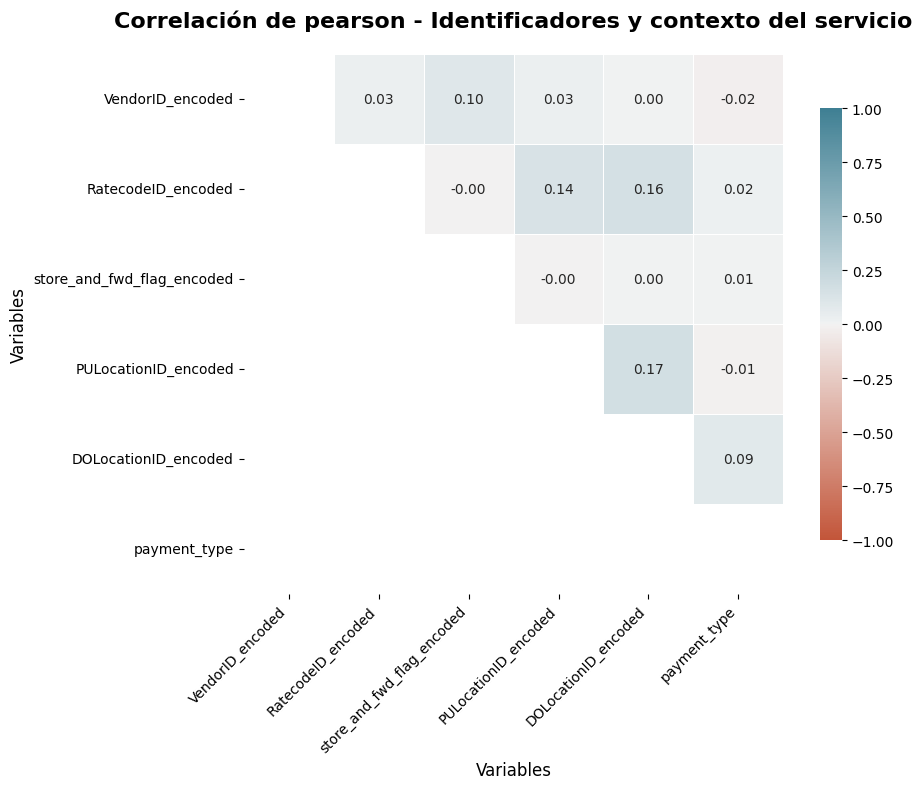

In [23]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - IDENTIFICADORES Y CONTEXTO DEL SERVICIO
🔄 Calculando correlaciones de spearman para 6 variables...

📈 RESUMEN ESTADÍSTICO - Identificadores y contexto del servicio
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: 0.012
Correlación máxima: 0.105
Correlación mínima: -0.138
Desviación estándar: 0.059

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 15 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


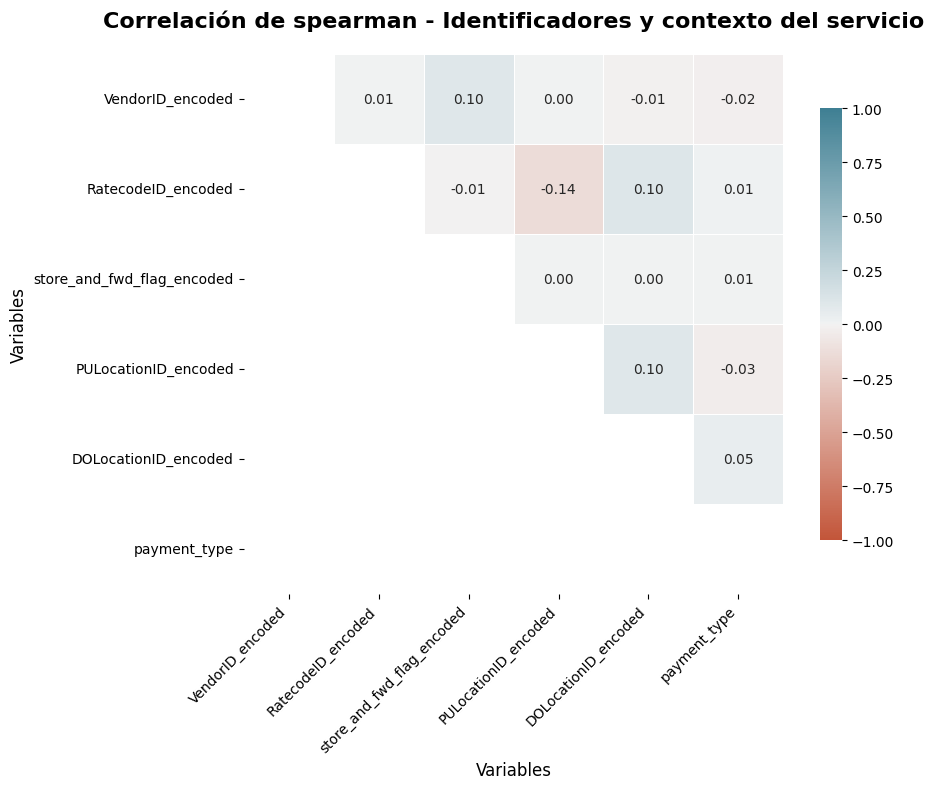

In [24]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
	  method = "spearman"
)

No hay correlación lineal entre las variables de este grupo.

*2.1.2) Características del viaje*

Variables:

- passenger_count_encoded
- trip_distance_encoded
- trip_duration_minutes_encoded
- average_speed_mph_encoded

In [25]:
grupo_de_variables = [
    'passenger_count_encoded',
    'trip_distance_encoded',
    'trip_duration_minutes_encoded',
    'average_speed_mph_encoded'
]

nombre_grupo = "Características del viaje"


📊 ANÁLISIS DE CORRELACIÓN - CARACTERÍSTICAS DEL VIAJE
🔄 Calculando correlaciones de pearson para 4 variables...

📈 RESUMEN ESTADÍSTICO - Características del viaje
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.070
Correlación máxima: 0.358
Correlación mínima: -0.000
Desviación estándar: 0.129

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 5 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


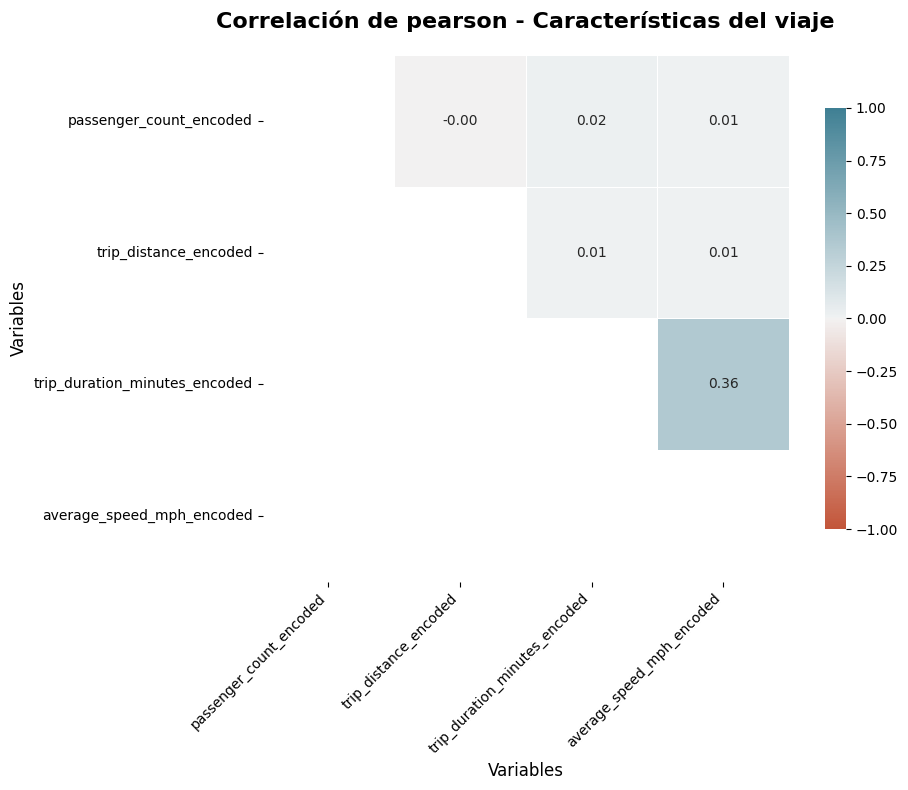

In [26]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - CARACTERÍSTICAS DEL VIAJE
🔄 Calculando correlaciones de spearman para 4 variables...

📈 RESUMEN ESTADÍSTICO - Características del viaje
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.281
Correlación máxima: 0.862
Correlación mínima: 0.018
Desviación estándar: 0.326

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 4 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
trip_distance_encoded ↔ trip_duration_minutes_encoded: 0.862


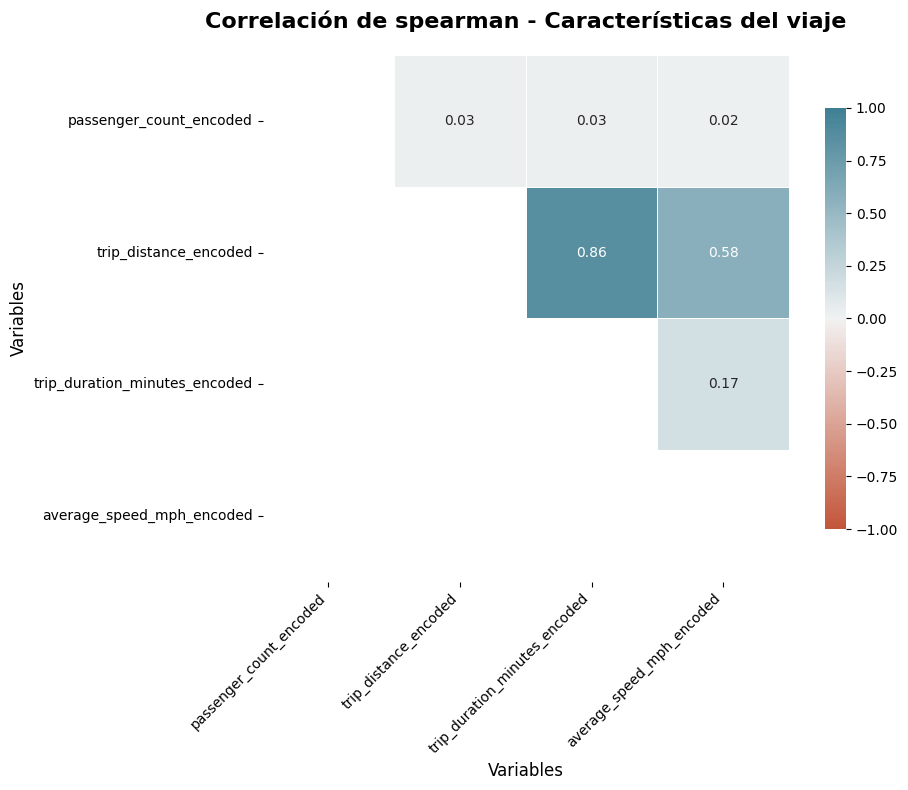

In [27]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Únicamente tenemos una correlación lineal moderada entre trip_duration_minutes y average_speed_mph.

Sin embargo, mediante Spearman vemos que existe una alta correlación no lineal entre trip_distance y trip_duration_minutes (parece lógico que haya relación entre distancia y duración del trayecto), y una correlación media entre trip_distance y average_speed_mph (distancia y velocidad media parece natural que estén ligadas pero no con una relación lineal, por eso sólo se muestra con Spearman).

Mantenemos todas estas variables.

*2.1.3) Componentes tarifarios base*

Variables:

- extra_encoded
- mta_tax_encoded
- fare_amount_encoded
- total_amount_encoded
- tolls_amount_encoded
- improvement_surcharge_encoded

In [28]:
grupo_de_variables = [
    'extra_encoded',
    'mta_tax_encoded',
    'fare_amount_encoded',
    'total_amount_encoded',
    'tolls_amount_encoded',
    'improvement_surcharge_encoded'
]

nombre_grupo = "Componentes tarifarios base"


📊 ANÁLISIS DE CORRELACIÓN - COMPONENTES TARIFARIOS BASE
🔄 Calculando correlaciones de pearson para 6 variables...

📈 RESUMEN ESTADÍSTICO - Componentes tarifarios base
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: 0.174
Correlación máxima: 0.979
Correlación mínima: -0.272
Desviación estándar: 0.323

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 2 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 12 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
fare_amount_encoded ↔ total_amount_encoded: 0.979
total_amount_encoded ↔ tolls_amount_encoded: 0.701


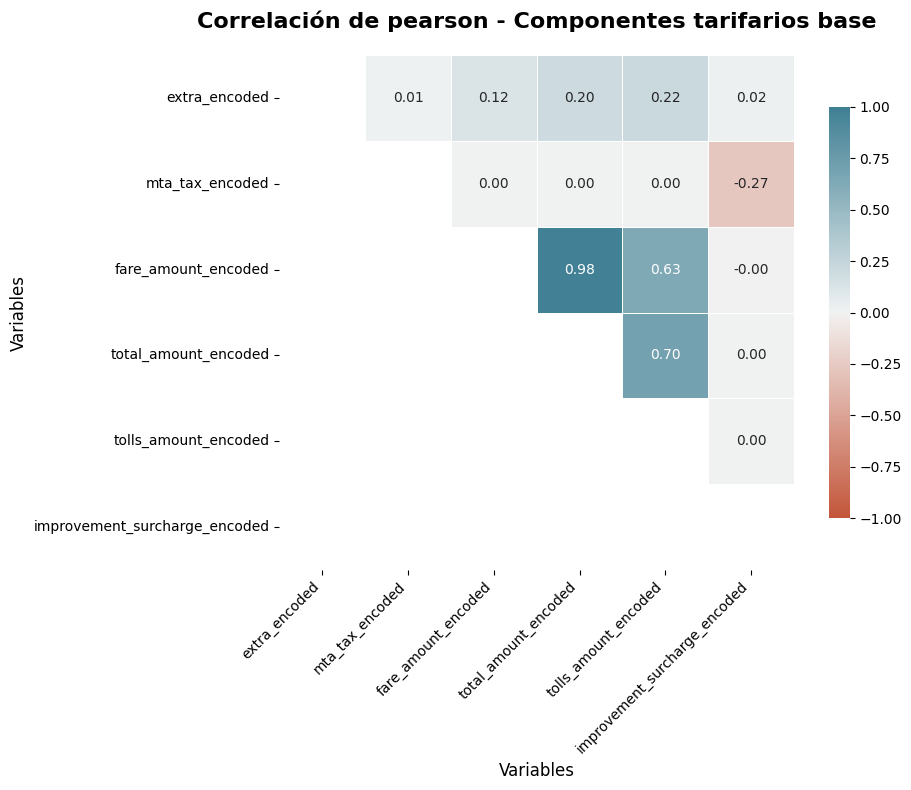

In [29]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - COMPONENTES TARIFARIOS BASE
🔄 Calculando correlaciones de spearman para 6 variables...

📈 RESUMEN ESTADÍSTICO - Componentes tarifarios base
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: 0.122
Correlación máxima: 0.964
Correlación mínima: -0.351
Desviación estándar: 0.287

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 11 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
fare_amount_encoded ↔ total_amount_encoded: 0.964


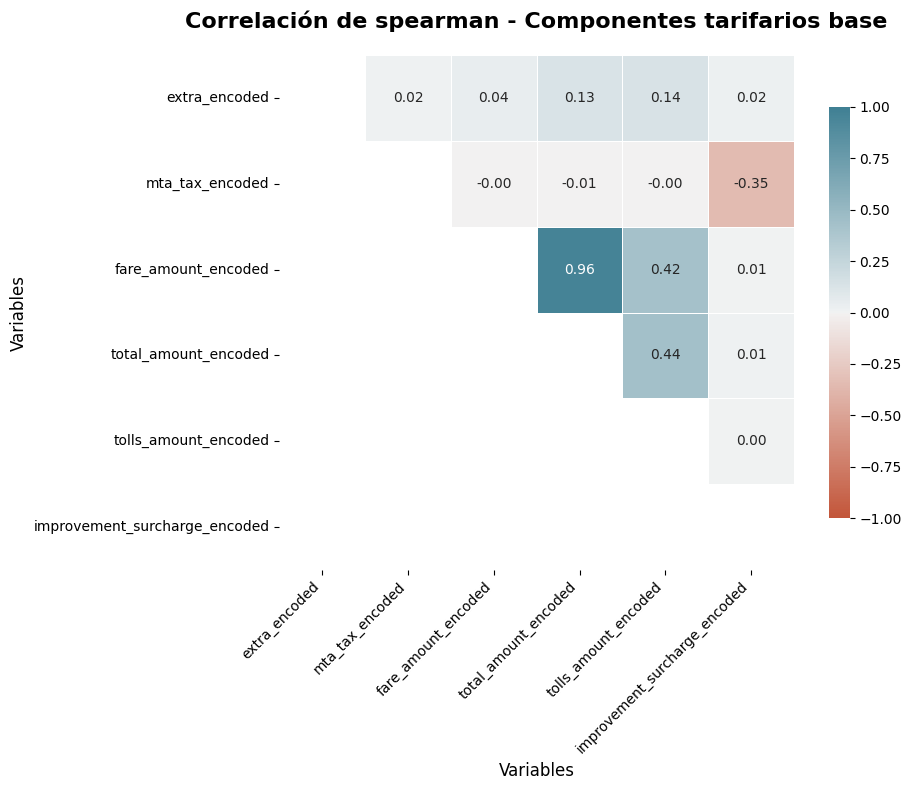

In [30]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Muy alta correlación lineal y no lineal entre fare_amount y total_amount, alta correlación lineal entre total_amount y tolls_amount, correlación lineal moderada entre fare_amount y tolls_amount, y no lineal también moderada entre mta_tax e improvement_surcharge.

Mantenemos total_amount y eliminamos fare_amount, ya que total_amount ya incluye a fare_amount.

La creación de toll_indicator (tolls_amount > 0), variable binaria que indica si el viaje incluye peajes, permite eliminar tolls_amount sin perder información.

*2.1.4) Nuevos cargos y propinas*

Variables:

- tip_amount_encoded
- congestion_surcharge_encoded
- airport_fee_encoded
- tip_percentage_encoded

In [31]:
grupo_de_variables = [
    'tip_amount_encoded',
    'congestion_surcharge_encoded',
    'airport_fee_encoded',
    'tip_percentage_encoded'
]

nombre_grupo = "Nuevos cargos y propinas"


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de pearson para 4 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.083
Correlación máxima: 0.545
Correlación mínima: -0.460
Desviación estándar: 0.332

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 3 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


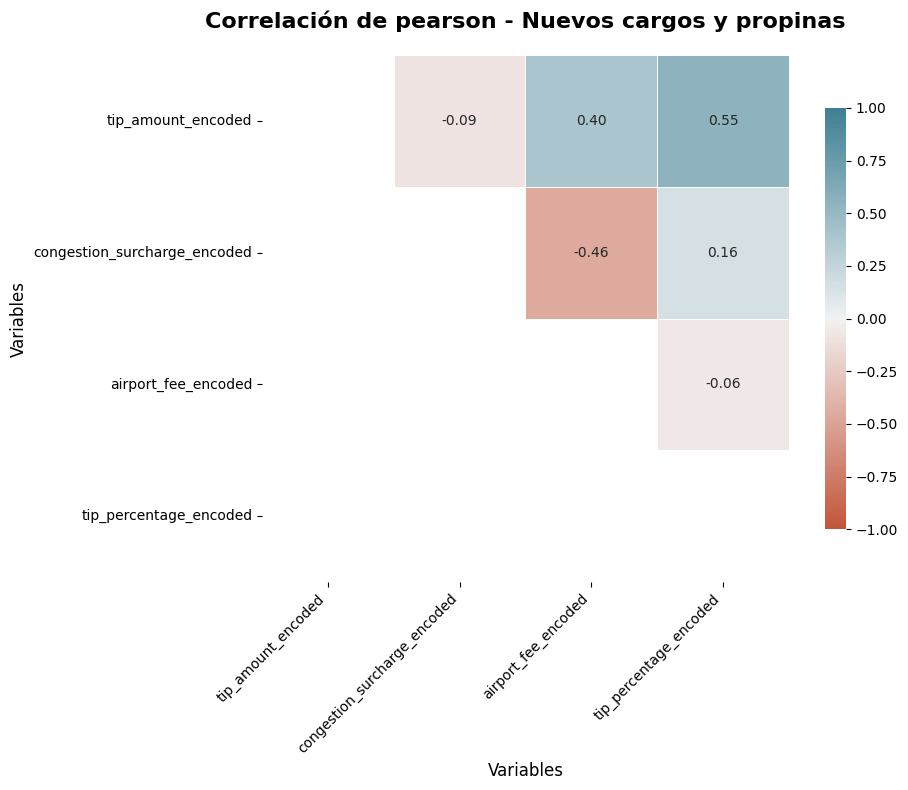

In [32]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de spearman para 4 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.099
Correlación máxima: 0.751
Correlación mínima: -0.460
Desviación estándar: 0.363

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 4 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
tip_amount_encoded ↔ tip_percentage_encoded: 0.751


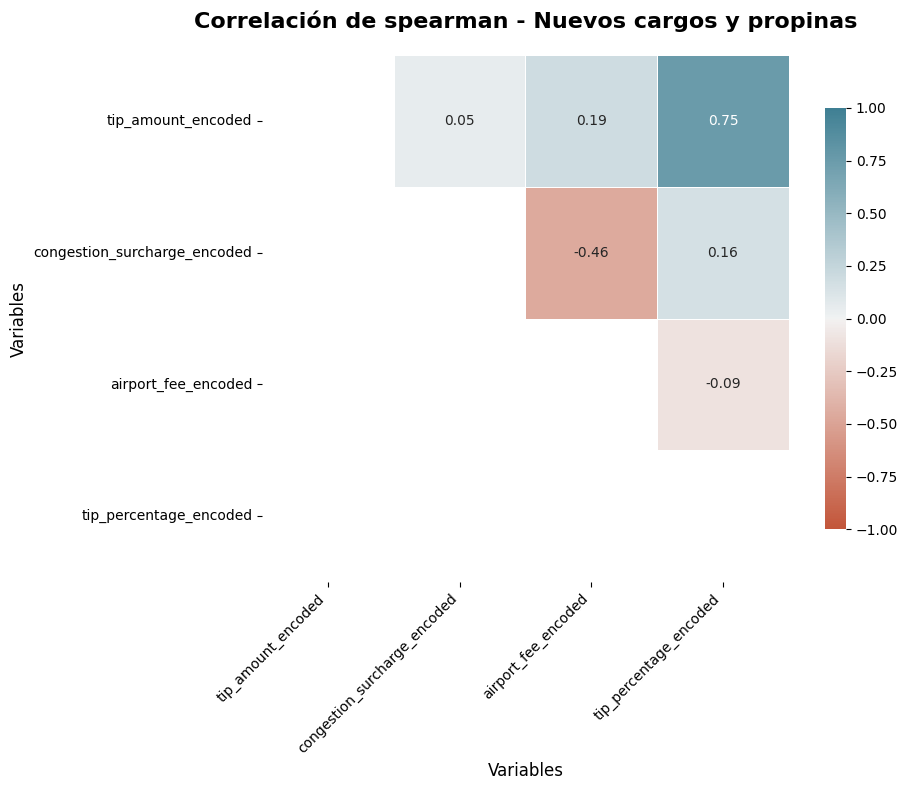

In [33]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Correlación lineal moderada entre tip_amount y tip_percentage, entre tip_amount y airport_fee, y entre congestion_surcharge y airport_fee. La correlación no lineal pasa a ser alta entre tip_amount y tip_percentage.

Podemos crear una nueva variable:

tip_score = tip_amount / fare_amount

tip_score indica la proporción de propina sobre la tarifa base; tip_percentage indica la proporción de propina sobre el total de la tarifa sin contar la propina; tip_score va a ser una variable más simple y útil que tip_percentage; por tanto, eliminamos tip_percentage.

También podemos crear la variable:

trip_extra_cost_ratio = ( airport_fee + congestion_surcharge ) / total_amount; nos permite eliminar airport_fee y congestion_surcharge.

 A raíz de lo anterior, hemos creado tip_socre y trip_extra_cost_ratio; además, también hemos creado toll_indicator, según vimos en el punto anterior. Vamos a repetir el mapa de correlación incluyendo estas tres nuevas variables.

- tip_score_encoded
- trip_extra_cost_ratio_encoded
- toll_indicator_encoded

In [34]:
grupo_de_variables_extended = [
    'tip_amount_encoded',
    'congestion_surcharge_encoded',
    'airport_fee_encoded',
    'tip_percentage_encoded',
    'toll_indicator_encoded',
    'tip_score_encoded',
    'trip_extra_cost_ratio_encoded'
]


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de pearson para 7 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 21
Correlación promedio: 0.097
Correlación máxima: 0.954
Correlación mínima: -0.494
Desviación estándar: 0.382

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 10 pares
Bajo (|r| ≤ 0.3): 10 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
tip_percentage_encoded ↔ tip_score_encoded: 0.954


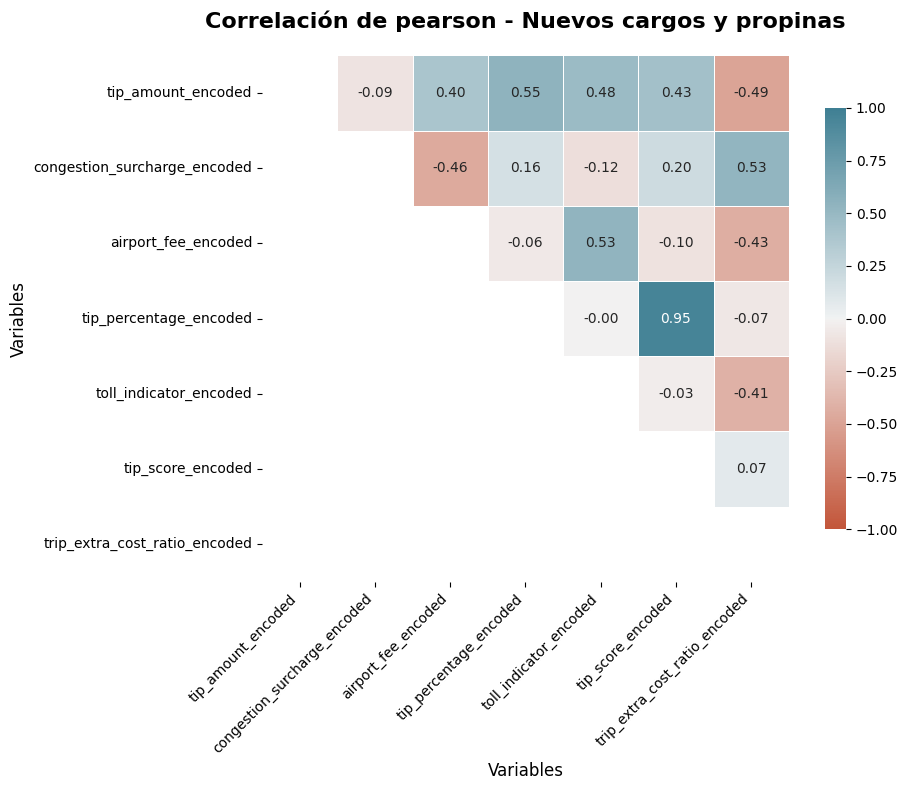

In [35]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables_extended,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de spearman para 7 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 21
Correlación promedio: 0.092
Correlación máxima: 0.883
Correlación mínima: -0.492
Desviación estándar: 0.378

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 2 pares
Moderado (0.3 < |r| ≤ 0.7): 7 pares
Bajo (|r| ≤ 0.3): 12 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
tip_amount_encoded ↔ tip_percentage_encoded: 0.751
tip_percentage_encoded ↔ tip_score_encoded: 0.883


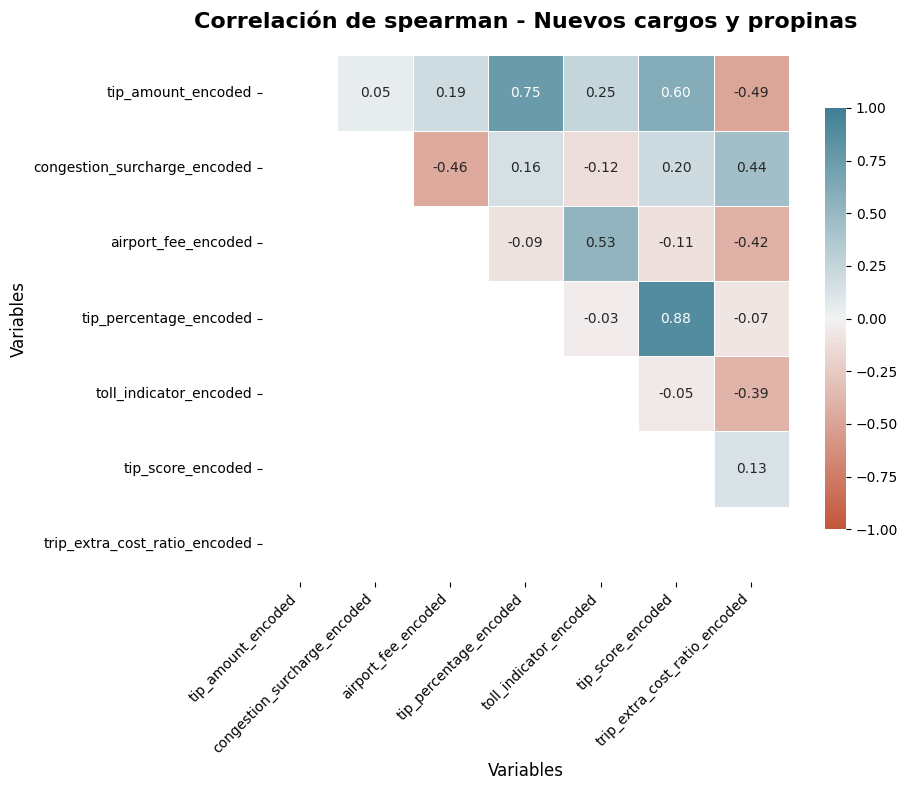

In [36]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables_extended,
    group_name = nombre_grupo,
    method = "spearman"
)

Al añadir toll_indicator, tip_score y trip_extra_cost_ratio, vemos que tip_score tiene alta correlación (lineal y no lineal) con tip_percentage y media (lineal) con tip_amount; toll_indicator tiene correlación media con airport_fee (lineal y no lineal) y con tip_amount (lineal); y trip_extra_cost_ratio tiene correlación media lineal y no lineal con congestion_surcharge, tip_amount, airport_fee y toll_indicator.

Eliminando las tres variables mencionadas antes, tip_percentage, airport_fee y congestion_surcharge, nos quedará unicamente correlación moderada de tip_amount con toll_indicator, tip_score y trip_extra_cost_ratio, y de toll_indicator con trip_extra_cost_ratio.

In [37]:
grupo_de_variables_clean = [
    'tip_amount_encoded',
    'toll_indicator_encoded',
    'tip_score_encoded',
    'trip_extra_cost_ratio_encoded'
]


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de pearson para 4 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.007
Correlación máxima: 0.477
Correlación mínima: -0.494
Desviación estándar: 0.372

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 4 pares
Bajo (|r| ≤ 0.3): 2 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


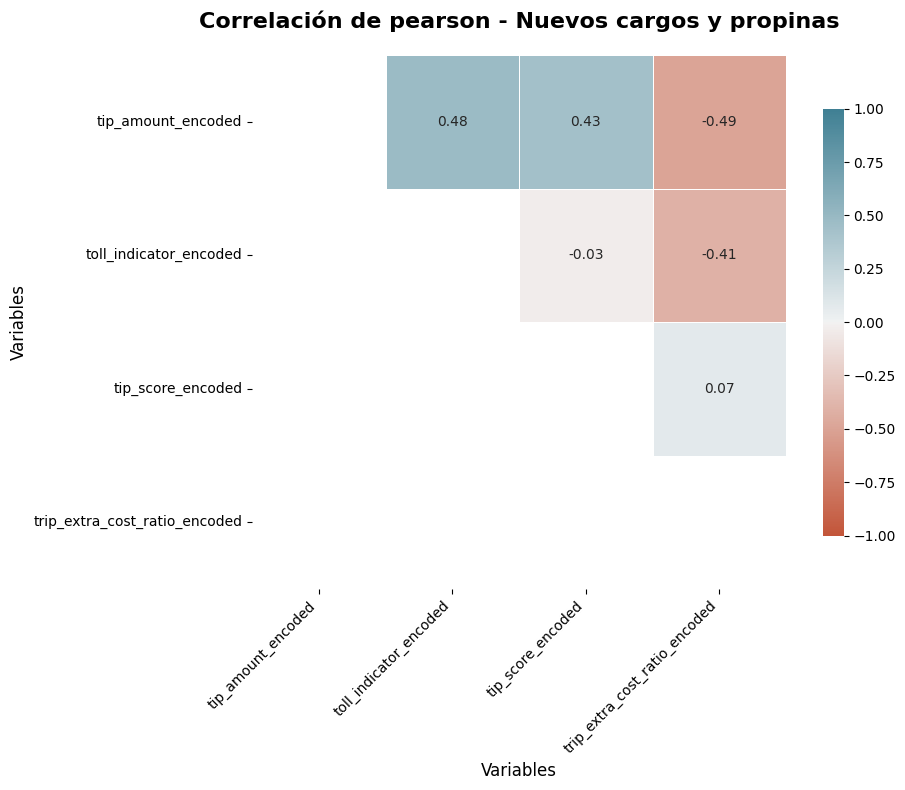

In [38]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables_clean,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - NUEVOS CARGOS Y PROPINAS
🔄 Calculando correlaciones de spearman para 4 variables...

📈 RESUMEN ESTADÍSTICO - Nuevos cargos y propinas
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: 0.007
Correlación máxima: 0.598
Correlación mínima: -0.492
Desviación estándar: 0.372

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 3 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


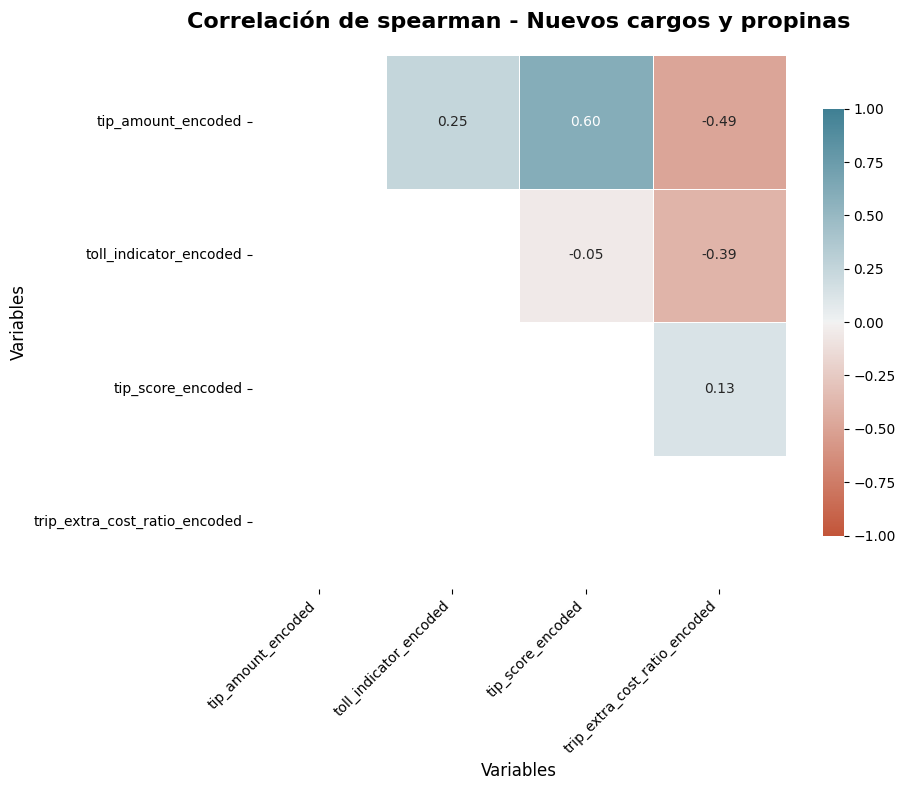

In [39]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables_clean,
    group_name = nombre_grupo,
    method = "spearman"
)

*2.1.5) Métricas derivadas*

Variables:

- fare_per_mile_encoded
- proportion_extra_charges_encoded

In [40]:
grupo_de_variables = [
    'fare_per_mile_encoded',
    'proportion_extra_charges_encoded'
]

nombre_grupo = "Métricas derivadas"


📊 ANÁLISIS DE CORRELACIÓN - MÉTRICAS DERIVADAS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - Métricas derivadas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.422
Correlación máxima: 0.422
Correlación mínima: 0.422
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


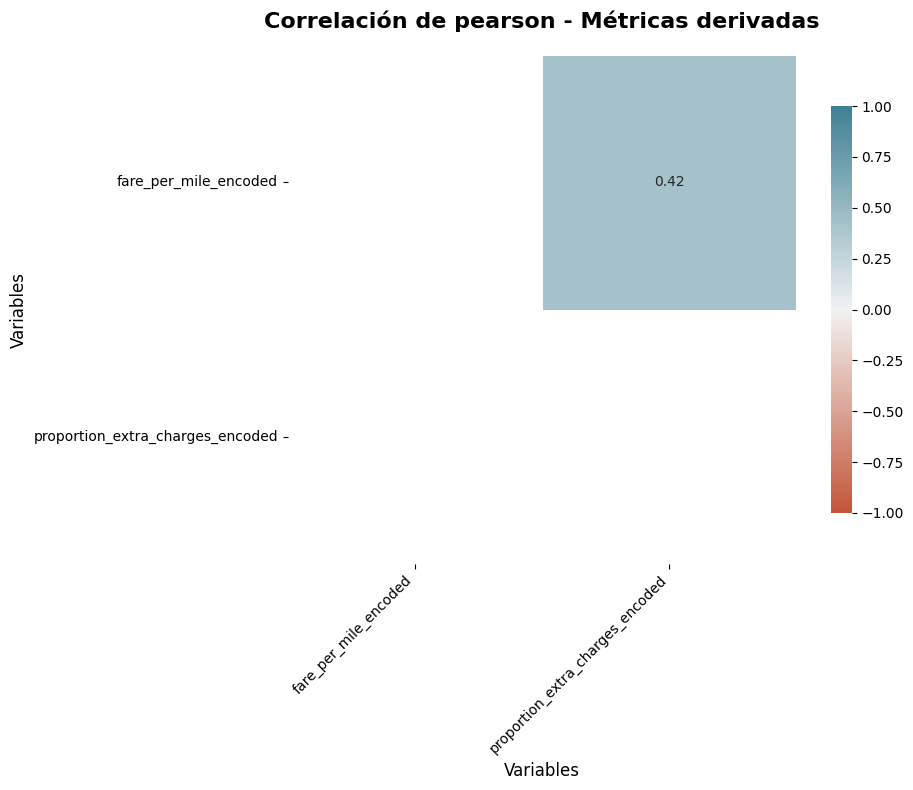

In [41]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - MÉTRICAS DERIVADAS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - Métricas derivadas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.481
Correlación máxima: 0.481
Correlación mínima: 0.481
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


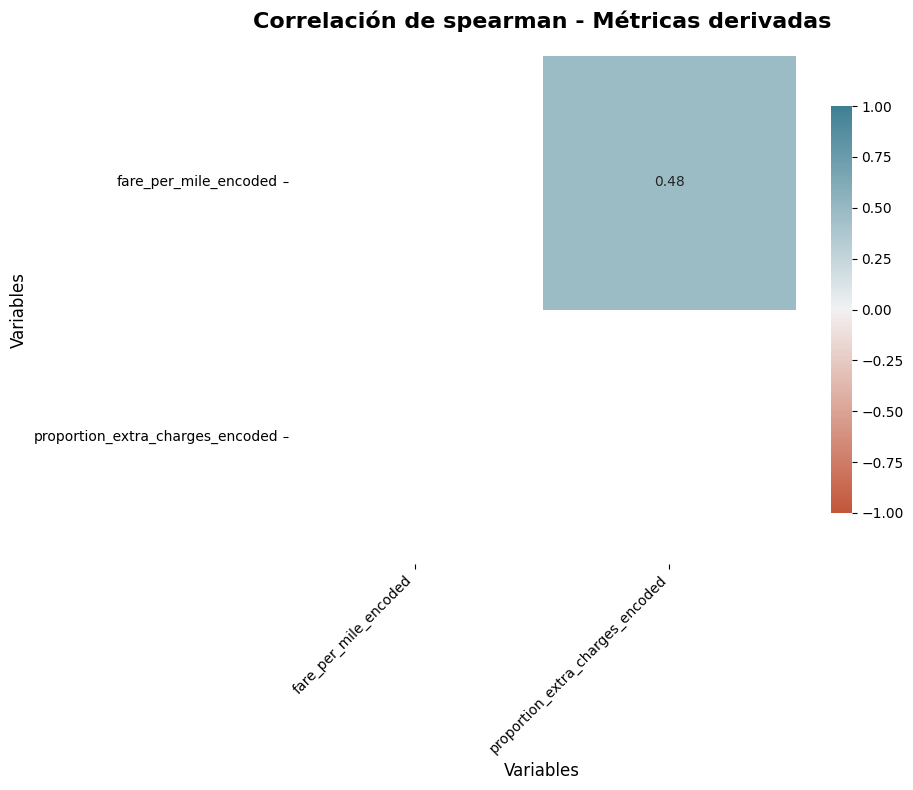

In [42]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Correlación moderada entre estas dos variables, fare_per_mile y proportion_extra_charges.

Hemos creado trip_extra_cost_ratio como hemos visto anteriormente, esta variable nos va a proporcionar mejor información que proportion_extra_charges, por lo que podemos eliminar esta última variable.

In [43]:
grupo_de_variables = [
    'fare_per_mile_encoded',
    'trip_extra_cost_ratio_encoded'
]

nombre_grupo = "Métricas derivadas"


📊 ANÁLISIS DE CORRELACIÓN - MÉTRICAS DERIVADAS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - Métricas derivadas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.539
Correlación máxima: 0.539
Correlación mínima: 0.539
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


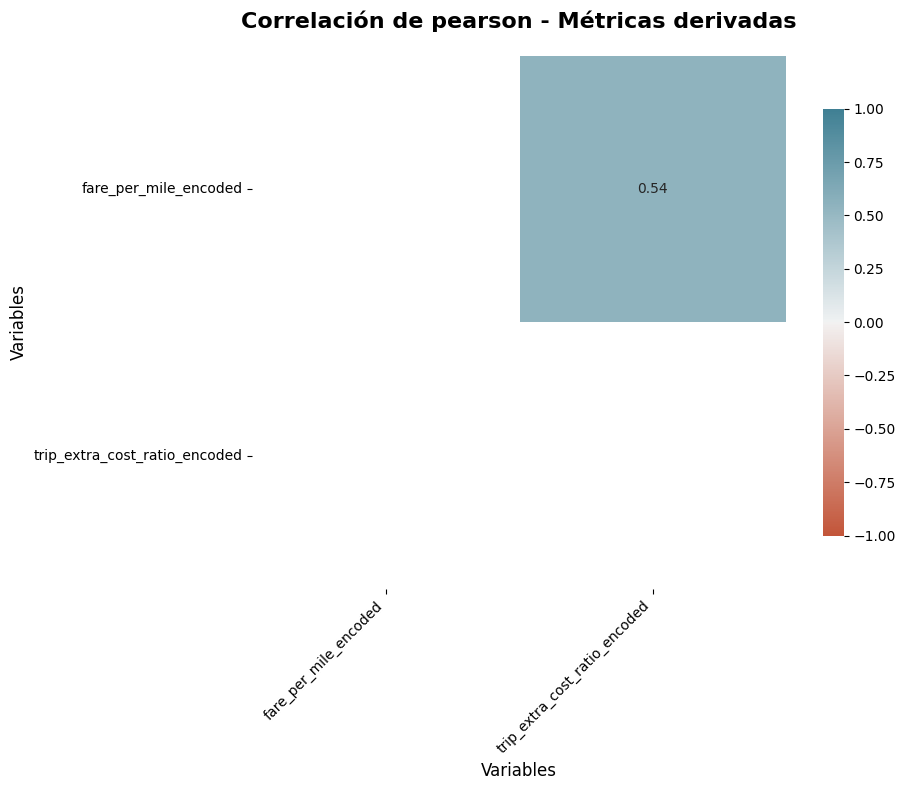

In [44]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - MÉTRICAS DERIVADAS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - Métricas derivadas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.623
Correlación máxima: 0.623
Correlación mínima: 0.623
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


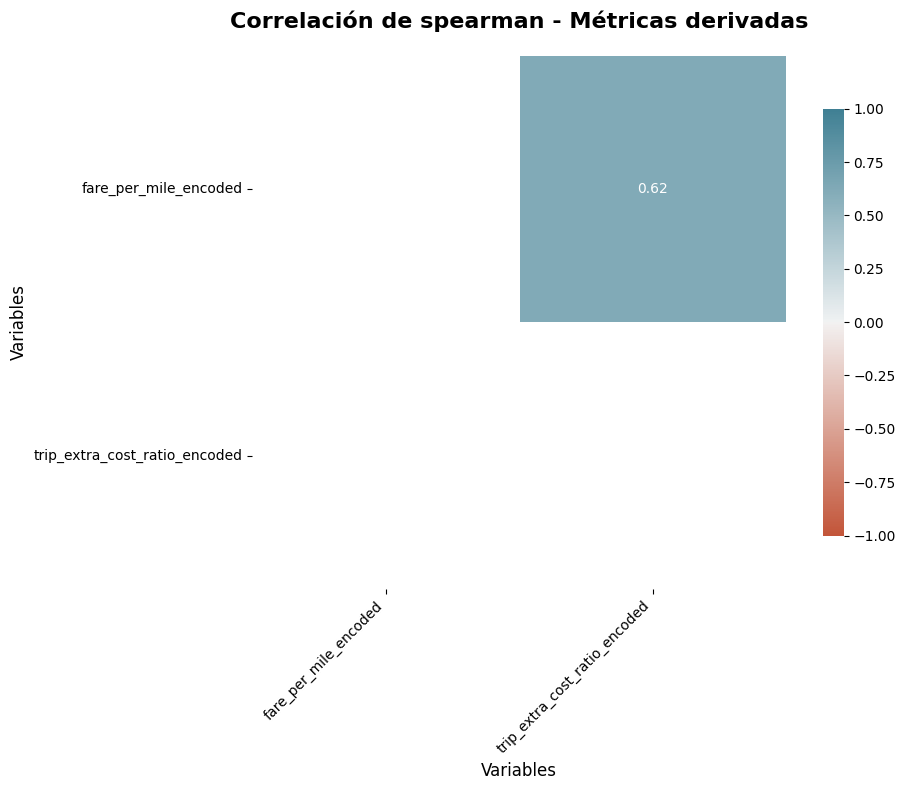

In [45]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Correlación moderada entre fare_per_mile y la nueva variable trip_extra_cost_ratio.

*2.1.6) Variables temporales inicio viaje*

Variables lineales:

- tpep_pickup_datetime_day
- tpep_pickup_datetime_dayofweek
- tpep_pickup_datetime_week

Variables cíclicas:

- pickup_hour
- is_weekend

Variables sinusoidales:

- tpep_pickup_datetime_dayofweek_sin
- tpep_pickup_datetime_dayofweek_cos
- pickup_hour_hour_sin
- pickup_hour_hour_cos

- Lineales

In [46]:
grupo_de_variables = [
    'tpep_pickup_datetime_day',
    'tpep_pickup_datetime_dayofweek',
    'tpep_pickup_datetime_week'
]

nombre_grupo = "Inicio viaje variables lineales"


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES LINEALES
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables lineales
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.116
Correlación máxima: 0.041
Correlación mínima: -0.254
Desviación estándar: 0.121

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 3 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


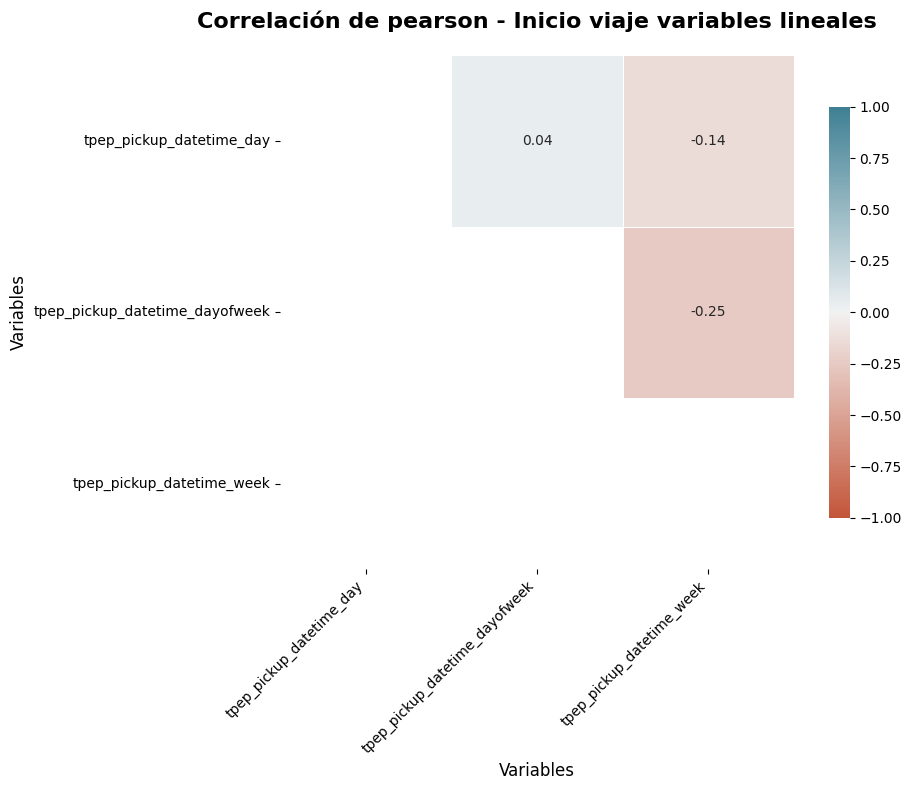

In [47]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES LINEALES
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables lineales
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.237
Correlación máxima: 0.826
Correlación mínima: -0.154
Desviación estándar: 0.424

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 2 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
tpep_pickup_datetime_day ↔ tpep_pickup_datetime_week: 0.826


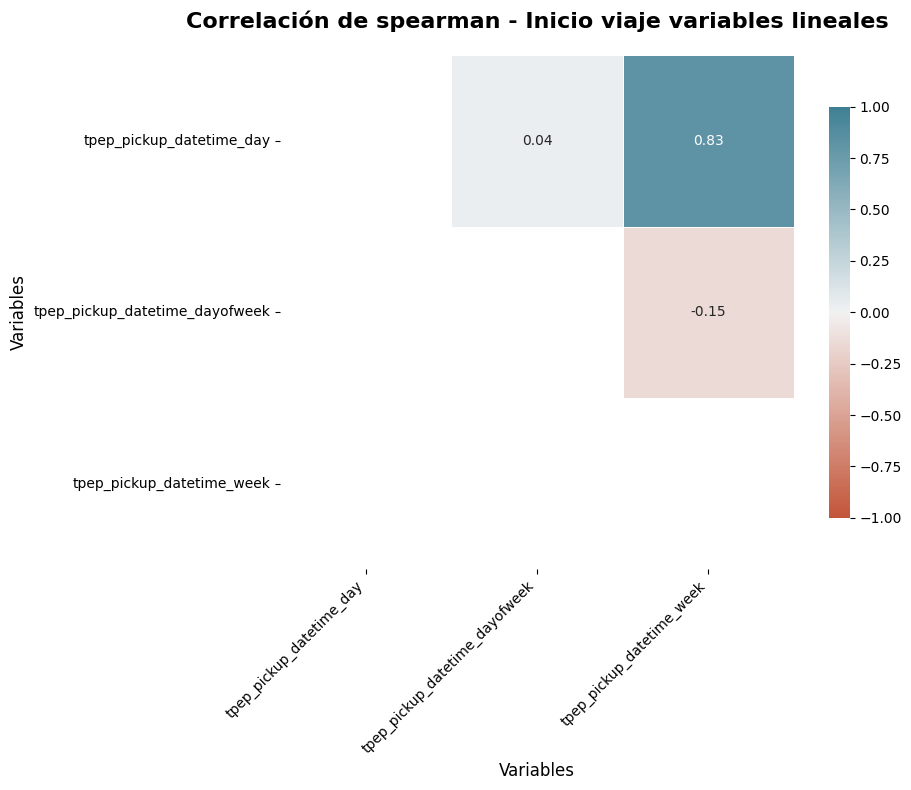

In [48]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

No hay correlación lineal entre estas variables, pero sí alta no lineal entre tpep_pickup_datetime_day y tpep_pickup_datetime_week. No hay lógicamente relación lineal entre el día y la semana, pero a medida que avanzan los días avanzan también las semanas aunque a saltos; es una relación no lineal detectada por Spearman.

Estas dos variables por tanto son dos formas muy correlacionadas de mostrar el instante de tiempo, interesa eliminar una de ellas. Para este estudio vamos a mantener tpep_pickup_datetime_day y vamos a eliminar tpep_pickup_datetime_week, ya que nos puede ser más interesante observar la evolución de los días más que la de las semanas.

- Cíclicas

In [49]:
grupo_de_variables = [
    'pickup_hour',
    'is_weekend'
]

nombre_grupo = "Inicio viaje variables cíclicas"


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES CÍCLICAS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables cíclicas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.111
Correlación máxima: -0.111
Correlación mínima: -0.111
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


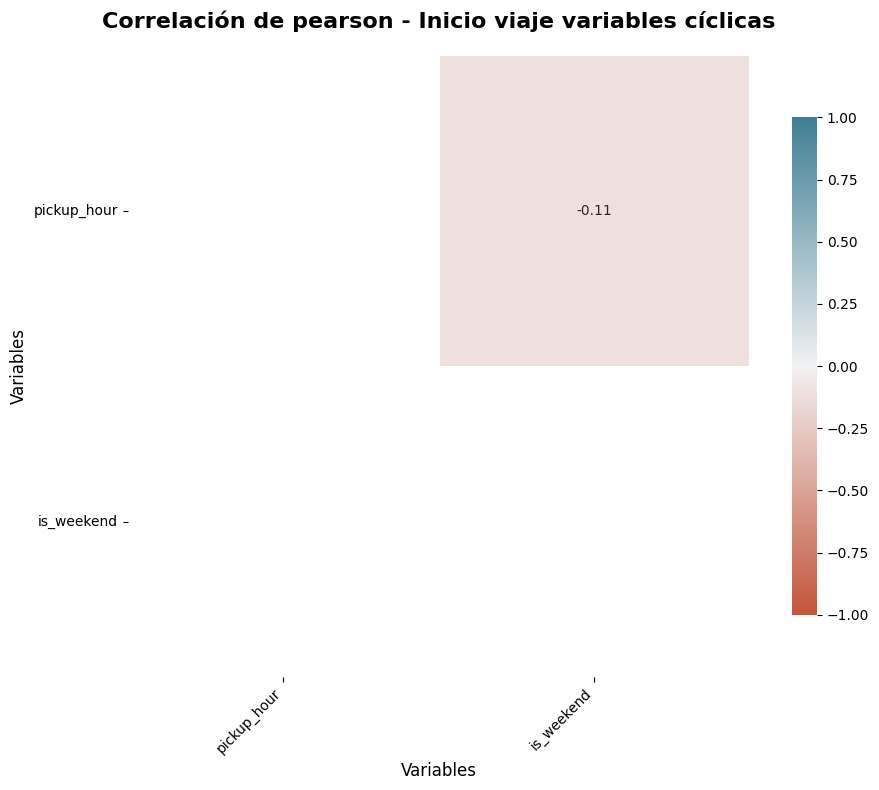

In [50]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES CÍCLICAS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables cíclicas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.068
Correlación máxima: -0.068
Correlación mínima: -0.068
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


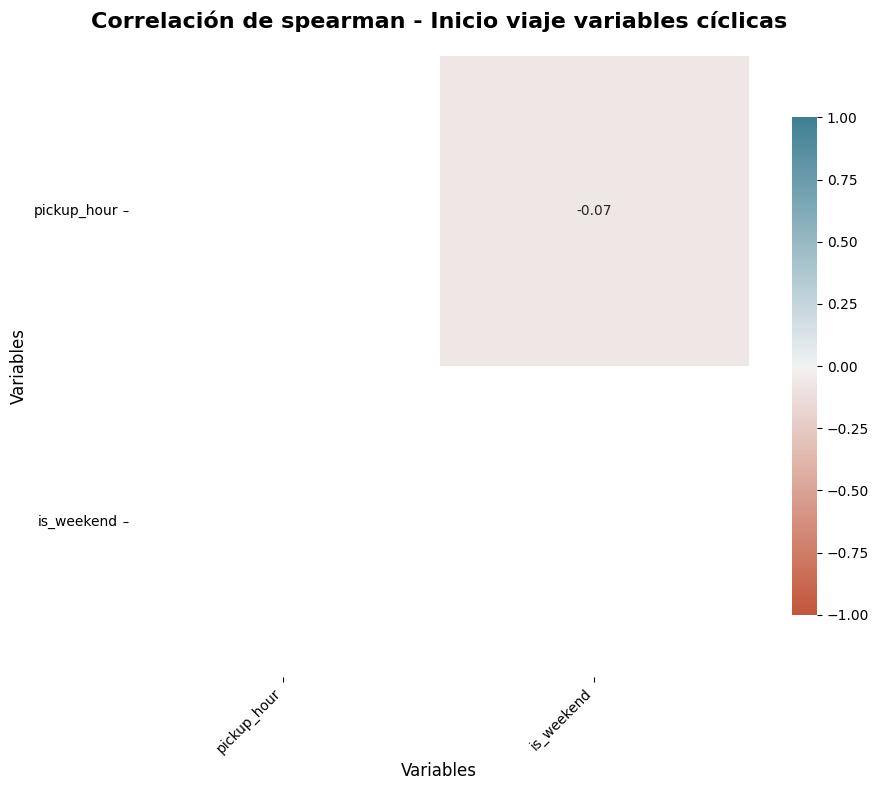

In [51]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

No hay correlación entre estas dos variables.

- Sinusoidales

In [52]:
grupo_de_variables = [
    'tpep_pickup_datetime_dayofweek_sin',
    'tpep_pickup_datetime_dayofweek_cos',
    'pickup_hour_hour_sin',
    'pickup_hour_hour_cos'
]

nombre_grupo = "Inicio viaje variables sinusoidales"


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES SINUSOIDALES
🔄 Calculando correlaciones de pearson para 4 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables sinusoidales
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: -0.033
Correlación máxima: 0.064
Correlación mínima: -0.200
Desviación estándar: 0.087

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 6 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


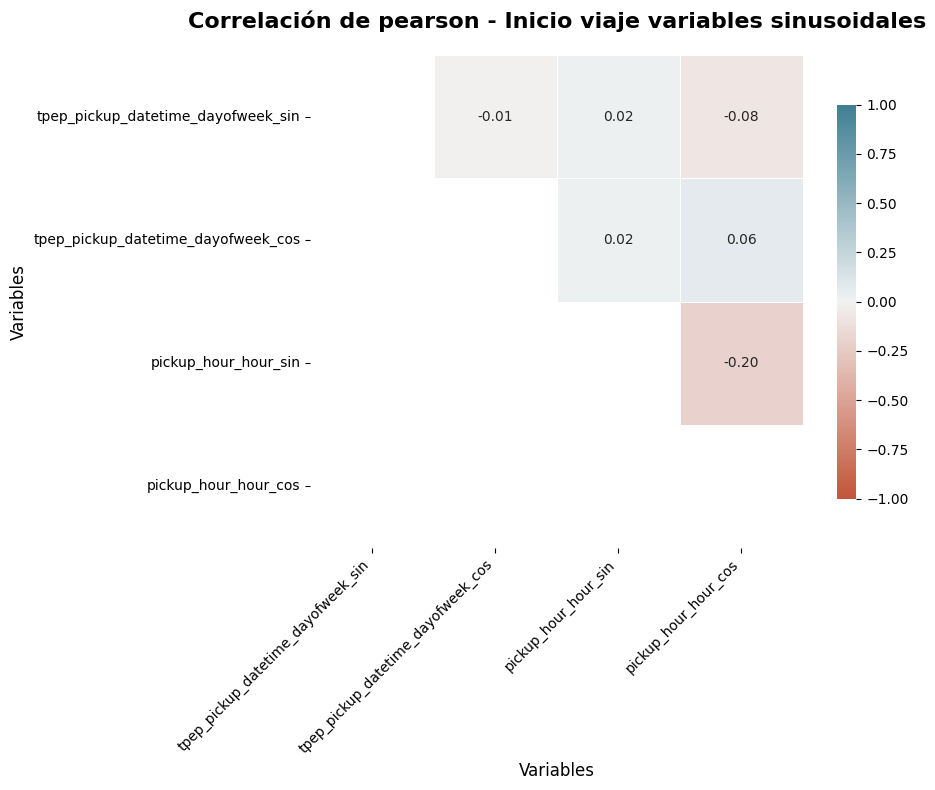

In [53]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - INICIO VIAJE VARIABLES SINUSOIDALES
🔄 Calculando correlaciones de spearman para 4 variables...

📈 RESUMEN ESTADÍSTICO - Inicio viaje variables sinusoidales
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: -0.010
Correlación máxima: 0.205
Correlación mínima: -0.276
Desviación estándar: 0.145

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 6 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


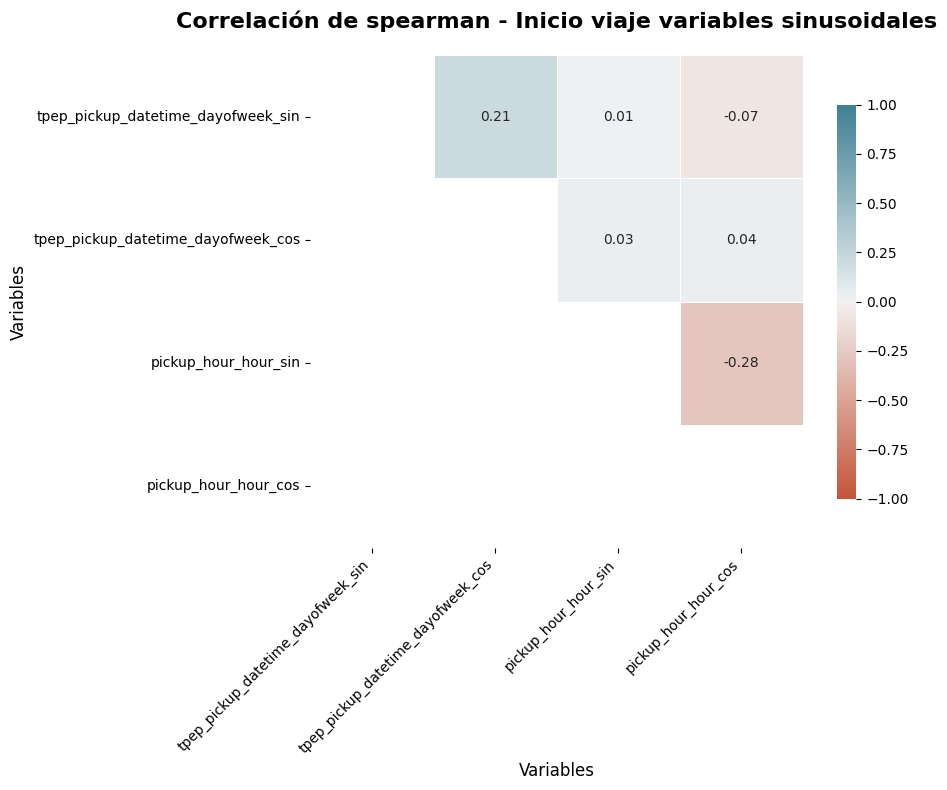

In [54]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

Variables sin correlación.

*2.1.7) Variables temporales final viaje*

Variables lineales:

- tpep_dropoff_datetime_day
- tpep_dropoff_datetime_dayofweek
- tpep_dropoff_datetime_week

Variables sinusoidales:

- tpep_dropoff_datetime_dayofweek_sin
- tpep_dropoff_datetime_dayofweek_cos

- Lineales

In [55]:
grupo_de_variables = [
    'tpep_dropoff_datetime_day',
    'tpep_dropoff_datetime_dayofweek',
    'tpep_dropoff_datetime_week'
]

nombre_grupo = "Final viaje variables lineales"


📊 ANÁLISIS DE CORRELACIÓN - FINAL VIAJE VARIABLES LINEALES
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - Final viaje variables lineales
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.116
Correlación máxima: 0.040
Correlación mínima: -0.253
Desviación estándar: 0.120

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 3 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


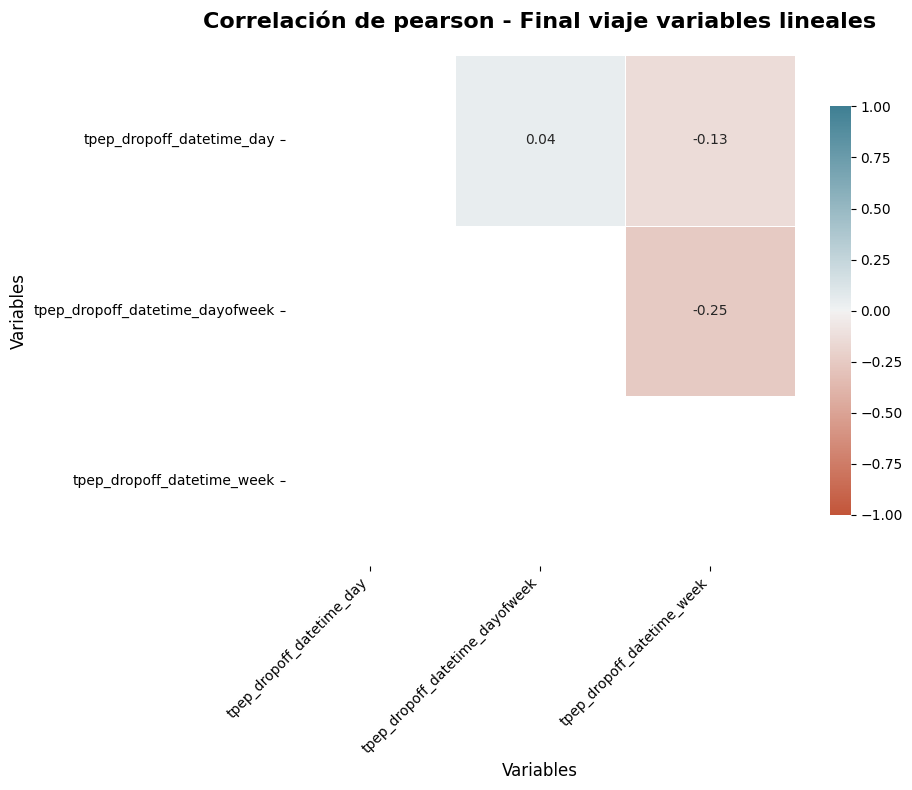

In [56]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - FINAL VIAJE VARIABLES LINEALES
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - Final viaje variables lineales
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.236
Correlación máxima: 0.826
Correlación mínima: -0.153
Desviación estándar: 0.424

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 2 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
tpep_dropoff_datetime_day ↔ tpep_dropoff_datetime_week: 0.826


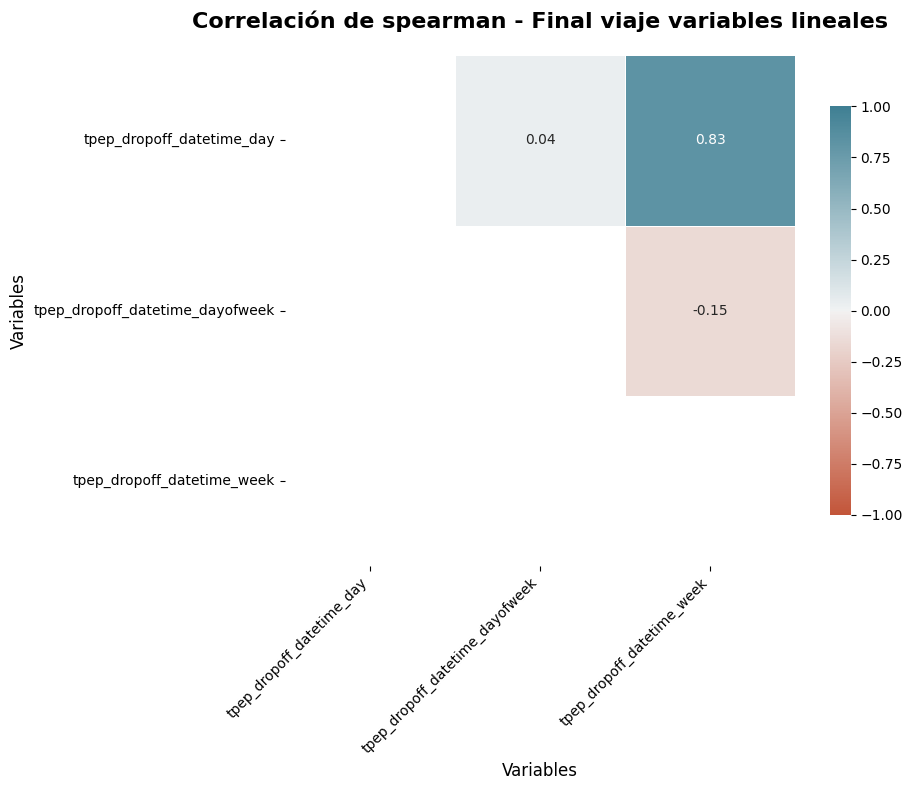

In [57]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

No hay correlación lineal entre estas variables; sí hay correlación no lineal alta entre tpep_dropoff_datetime_day y tpep_dropoff_datetime_week.

El razonamiento con respecto a estas dos variables es análogo al ya realizado para tpep_pickup_datetime_day y tpep_pickup_datetime_week; por tanto, vamos a eliminar tpep_dropoff_datetime_week.

- Sinusoidales

In [58]:
grupo_de_variables = [
    'tpep_dropoff_datetime_dayofweek_sin',
    'tpep_dropoff_datetime_dayofweek_cos'
]

nombre_grupo = "Final viaje variables sinusoidales"


📊 ANÁLISIS DE CORRELACIÓN - FINAL VIAJE VARIABLES SINUSOIDALES
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - Final viaje variables sinusoidales
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.013
Correlación máxima: -0.013
Correlación mínima: -0.013
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


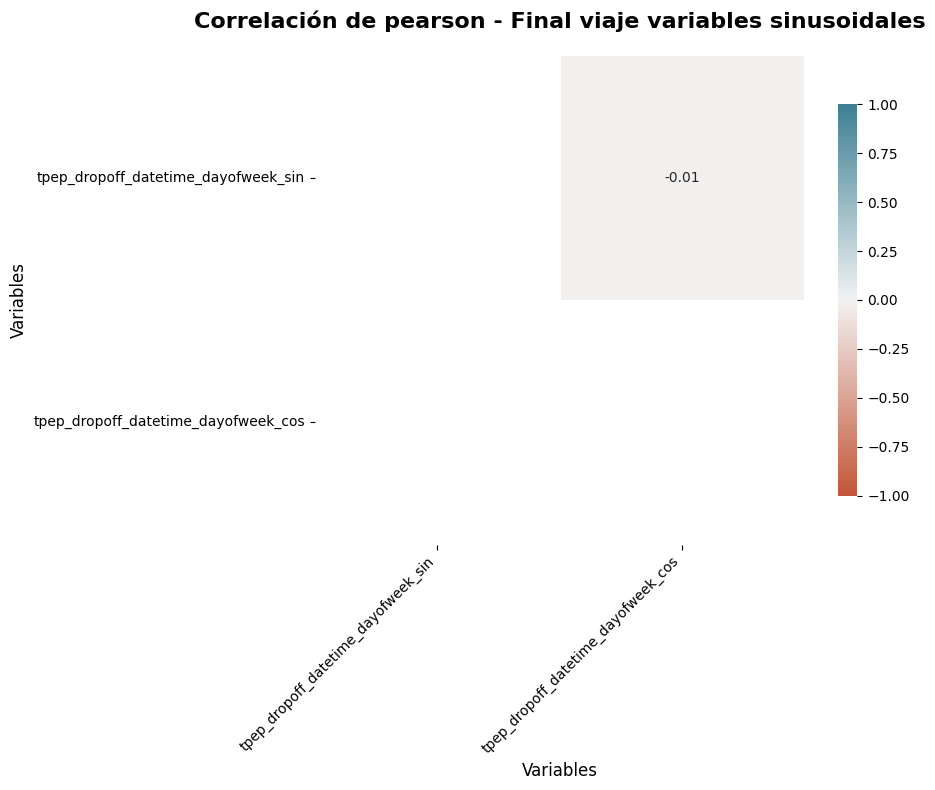

In [59]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo
)


📊 ANÁLISIS DE CORRELACIÓN - FINAL VIAJE VARIABLES SINUSOIDALES
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - Final viaje variables sinusoidales
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.205
Correlación máxima: 0.205
Correlación mínima: 0.205
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares

🔍 CORRELACIONES ALTAS (|r| > 0.7)
--------------------------------------------------
No se encontraron correlaciones altas.


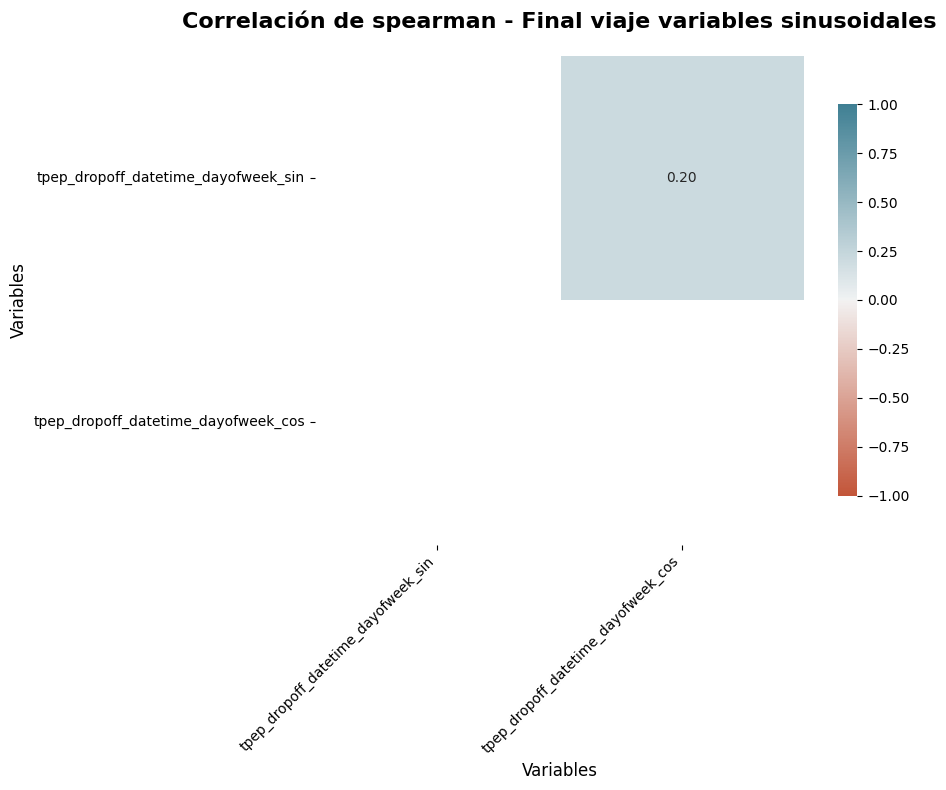

In [60]:
results_grupo = analyze_correlations(
    ds_spark = ds_for_correlation,
    variables_list = grupo_de_variables,
    group_name = nombre_grupo,
    method = "spearman"
)

No hay correlación entre estas variables.

*2.1.8) Eliminación de variables*

Como hemos visto, podemos eliminar:

- fare_amount
- tolls_amount
- tip_percentage
- airport_fee
- congestion_surcharge
- proportion_extra_charges
- tpep_pickup_datetime_week
- tpep_dropoff_datetime_week

In [61]:
cols_a_borrar = [
    "fare_amount_encoded",
    "tolls_amount_encoded",
    "tip_percentage_encoded",
    "airport_fee_encoded",
    "congestion_surcharge_encoded",
    "proportion_extra_charges_encoded",
    "tpep_pickup_datetime_week",
    "tpep_dropoff_datetime_week"
]

In [62]:
ds_for_correlation_clean = ds_for_correlation.drop(*cols_a_borrar)

In [63]:
ds_for_correlation_clean.columns

['payment_type',
 'pickup_hour',
 'is_weekend',
 'PULocationID_encoded',
 'DOLocationID_encoded',
 'passenger_count_encoded',
 'RatecodeID_encoded',
 'trip_distance_encoded',
 'extra_encoded',
 'tip_amount_encoded',
 'improvement_surcharge_encoded',
 'mta_tax_encoded',
 'total_amount_encoded',
 'trip_duration_minutes_encoded',
 'average_speed_mph_encoded',
 'fare_per_mile_encoded',
 'tpep_pickup_datetime_day',
 'tpep_pickup_datetime_dayofweek',
 'tpep_pickup_datetime_dayofweek_sin',
 'tpep_pickup_datetime_dayofweek_cos',
 'tpep_dropoff_datetime_day',
 'tpep_dropoff_datetime_dayofweek',
 'tpep_dropoff_datetime_dayofweek_sin',
 'tpep_dropoff_datetime_dayofweek_cos',
 'VendorID_encoded',
 'store_and_fwd_flag_encoded',
 'pickup_hour_hour_sin',
 'pickup_hour_hour_cos',
 'tip_score_encoded',
 'trip_extra_cost_ratio_encoded',
 'toll_indicator_encoded']

In [64]:
print("Número de variables:", len(ds_for_correlation_clean.columns))

Número de variables: 31


In [65]:
# limpia la memoria
ds_for_correlation.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, tolls_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, fare_amount_encoded: double, total_amount_encoded: double, congestion_surcharge_encoded: double, airport_fee_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, tip_percentage_encoded: double, fare_per_mile_encoded: double, proportion_extra_charges_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_week: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_week: int, tpep_dropoff_datetime_dayofweek_sin: dou

# **Guarda los datos**

In [66]:
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_clean_251109"

In [67]:
# guarda dataframe en formato Parquet
save_parquet(ds_for_correlation_clean, dir_dataset)

💾 Guardando DataFrame en /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_clean_251109...
📊 Registros a guardar: 3066715
✅ Dataframe guardado correctamente en /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_clean_251109


True

In [68]:
# limpia la memoria
ds_for_correlation_clean.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, total_amount_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, fare_per_mile_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_dayofweek_sin: double, tpep_dropoff_datetime_dayofweek_cos: double, VendorID_encoded: int, store_and_fwd_flag_encoded: int, pickup_hour_hour_sin: double, pickup_hour_hour_cos: double, tip_score_encoded: double, trip_extra_cost_ratio_encoded: double, toll_indicator_encoded: int]

In [69]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
